# ffp

> A module to model and calculate the properties of Free Floating Planets (FFPs), such as density, mass, distance, and velocity distribution.

In [2]:
#| default_exp ffp

In [105]:
#| hide
from nbdev.showdoc import *

In [172]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *
from LensCalcPy.galaxy import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad, dblquad, tplquad
from scipy.interpolate import interp1d, interp2d
import pickle
import functools
from pathos.multiprocessing import ProcessingPool as Pool

import functools

from fastcore.test import *
from tqdm import tqdm


In [173]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
#| export 

class Ffp(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                p: float = 1, # Mass function power law index
                m_min: float = 1e-15, # Minimum mass in Msun
                m_max: float = 1e-3, # Maximum mass in Msun
                mw_model: MilkyWayModel = None,
                m31_model: M31Model = None, 
                l = None, # Galactic longitude
                b = None, # Galactic latitude
                u_t = 1, #threshold impact parameter in point-source limit
                ds = 770,
                ):
        """
        Initialize the PBH population
        """

        self.ut_interp = ut_func_new

        self.p = p
        #Define range of power law we want to consider
        self.m_min = m_min
        self.m_max = m_max
        self.M_norm = 1 #solar mass
        # self.Z = self.pl_norm(self.p)
        self.Z = self.pl_norm_new()

        # Instantiate or use existing MilkyWayModel and M31Model
        self.mw_model = mw_model or MilkyWayModel(mw_parameters)
        self.m31_model = m31_model or M31Model(m31_parameters)

        if l is None:
            raise ValueError("Galactic longitude must be specified")
        if b is None:
            raise ValueError("Galactic latitude must be specified")
        self.l = l
        self.b = b
        self.u_t = u_t
        self.ds = ds

    
    def __str__(self) -> str:
        return f"FFP with power law dN / dlogM ~ m^-{self.p}"
    __repr__ = __str__


    def dN_dM(self, A, M, M_norm, p):
        return A * (M/M_norm)**-p / M
    
    def dN_dM_wrapper(self, M):
        return self.dN_dM(1, M, self.M_norm, self.p)
    
    def dN_dlogM(self, A, log10M, M_norm, p):
        M = 10**log10M
        return A * (M/self.M_norm)**-p
    
    def dN_dlogM_wrapper(self, M):
        return self.dN_dlogM(1, M, self.M_norm, self.p)
    
    def pl_norm_new(self):
        return 1/abs(nquad(self.dN_dlogM_wrapper,[[np.log10(self.m_min), np.log10(self.m_max)]], opts={'points': [np.log10(self.m_min), np.log10(self.m_min*1e3)]})[0])

    def mass_func(self, log10m):
        #M_norm = 1 solar mass for now. This is dN/dlogM
        m = 10**log10m
        return self.Z * (m/1)**-self.p
    
    def pl_norm(self, p):
        N_ffp = 1 # Number of FFPs per star
        return N_ffp/abs(nquad(self.mass_func,[[self.m_min, self.m_max]], opts={'points': [self.m_min, self.m_min*1e3]})[0])

    def differential_rate_integrand(self, umin, d, mf, t, dist_func, density_func, v_disp_func, finite=False):
        r = dist_func(d, self.l, self.b)
        ut = self.umin_upper_bound(d, mf) if (self.ut_interp and finite) else self.u_t
        if ut <= umin:
            return 0
        v_rad = velocity_radial(d, mf, umin, t * htosec, ut)  
        v_disp = v_disp_func(r)
        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                        #For FFP number density, use stellar density for 1 solar mass stars
                density_func(d) / (1 * v_disp**2) *  
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)) *
                1)

    def differential_rate(self, t, integrand_func, finite=False):
        num = 40  # number of discretization points, empirically, result levels off for >~ 40
        mf_values = np.linspace(np.log10(self.m_min), np.log10(self.m_max), num=num)

        result = 0
        for i in range(num):
            mf = mf_values[i]
            if i == 0:  # for the first point
                dm = mf_values[i+1] - mf_values[i]
            elif i < num - 1:  # for middle points
                dm = ((mf_values[i+1] - mf_values[i]) + (mf_values[i] - mf_values[i-1])) / 2
            else:  # for the last point
                dm = mf_values[i] - mf_values[i-1]
            if finite:
                single_result, error = dblquad(integrand_func, 
                                            0, self.ds, 
                                            lambda d: 0, 
                                            lambda d: self.umin_upper_bound(d, 10**mf),
                                            # args=(mf, t),
                                            args=(10**mf, t),
                                            # epsabs=0,
                                            # epsrel=1e-2,
                                            )
            else:
                single_result, error = dblquad(integrand_func,
                                               #Without finite size effects, integral blows up at M31 center
                                            0, self.ds*0.99,
                                            lambda d: 0, 
                                            lambda d: self.u_t,
                                            args=(10**mf, t),
                                            # epsabs=0,
                                            # epsrel=1e-2,
                                            )
            # if single_result != 0 and error/abs(single_result) >=1:
                # print("Warning: error in differential rate integration is large: {}".format(error/abs(single_result)))
            
            result += single_result * ((10**mf/1) ** -self.p) * dm # multiply by mass function and by dlogm. This is for dN/dlogM

        result *= self.Z  # normalization
        return result
    
    def differential_rate_monochromatic(self, t, integrand_func, finite=False, m=1e-10):
    
        if finite:
            result, error = dblquad(integrand_func, 
                                        0, self.ds, 
                                        lambda d: 0, 
                                        lambda d: self.umin_upper_bound(d, m),
                                        args=(m, t),
                                        )
        else:
            result, error = dblquad(integrand_func,
                                            #Without finite size effects, integral blows up at M31 center
                                        0, self.ds*0.99,
                                        lambda d: 0, 
                                        lambda d: self.u_t,
                                        args=(m, t),
                                        )
        return result
        
    def differential_rate_integrand_mw(self, umin, d, mf, t, finite=False, vel_func=None):
        if vel_func is None:
            vel_func = self.mw_model.velocity_dispersion_stars
        return self.differential_rate_integrand(umin, d, mf, t, self.mw_model.dist_center, self.mw_model.density_stars, vel_func, finite=finite)

    def differential_rate_mw(self, t, finite=False, v_disp=None):
        if v_disp:
            vel_func = lambda r: v_disp
            f = functools.partial(self.differential_rate_integrand_mw, vel_func=vel_func)
            return self.differential_rate(t, f, finite=finite)
        return self.differential_rate(t, self.differential_rate_integrand_mw, finite=finite)
    
    def differential_rate_mw_monochromatic(self, t, finite=False, m=1e-10):
        return self.differential_rate_monochromatic(t, self.differential_rate_integrand_mw, finite=finite, m=m)

    def differential_rate_integrand_m31(self, umin, d, mf, t, finite=False, vel_func=None):
        if vel_func is None:
            vel_func = self.m31_model.velocity_dispersion_stars
        return self.differential_rate_integrand(umin, d, mf, t, self.m31_model.dist_center, self.m31_model.density_stars, vel_func, finite=finite)

    def differential_rate_m31(self, t, finite=False, v_disp=None):
        if v_disp:
            vel_func = lambda r: v_disp
            f = functools.partial(self.differential_rate_integrand_m31, vel_func=vel_func)
            return self.differential_rate(t, f, finite=finite)
        return self.differential_rate(t, self.differential_rate_integrand_m31, finite=finite)
    
    def differential_rate_m31_monochromatic(self, t, finite=False, m=1e-10):
        return self.differential_rate_monochromatic(t, self.differential_rate_integrand_m31, finite=finite, m=m)

    def umin_upper_bound(self, d, m):
        if self.ut_interp is None:
            self.make_ut_interp()
        rho = rho_func(m, d, self.ds)
        return self.ut_interp(rho, magnification(self.u_t))
        # return self.ut_interp(d, m)[0]
    
    def differential_rate_total(self, t, finite=False):
        return self.differential_rate_mw(t, finite=finite) + self.differential_rate_m31(t, finite=finite)
 
    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]

In [200]:
p = 0.9
f = Ffp(p, l = l, b = b, u_t = 1)
ts = np.logspace(-2, 1, num=20)
f

FFP with power law dN / dlogM ~ m^-0.9

In [201]:
diff_rates_finite_mw = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw.append(f.differential_rate_mw(t, finite=True))

diff_rates_finite_m31 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31.append(f.differential_rate_m31(t, finite=True))

Computing differential rates for MW (finite=True): 100%|██████████| 20/20 [00:59<00:00,  2.96s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


In [189]:
diff_rates_finite_mw_60 = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw_60.append(f.differential_rate_mw(t, finite=True, v_disp=60))

diff_rates_finite_m31_120 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31_120.append(f.differential_rate_m31(t, finite=True, v_disp=120))

Computing differential rates for MW (finite=True): 100%|██████████| 20/20 [01:05<00:00,  3.29s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


In [190]:
diff_rates_finite_mw_15 = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw_15.append(f.differential_rate_mw(t, finite=True, v_disp=15))

diff_rates_finite_m31_30 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31_30.append(f.differential_rate_m31(t, finite=True, v_disp=30))

Computing differential rates for MW (finite=True): 100%|██████████| 20/20 [00:55<00:00,  2.77s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


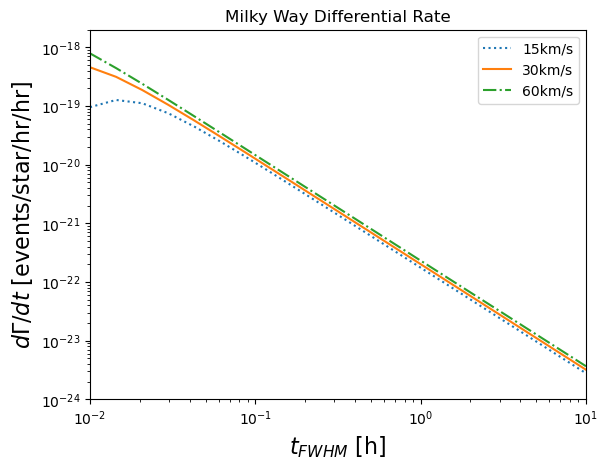

In [202]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw_15), label="15km/s", linestyle=':')
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw), label="30km/s", linestyle='-')
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw_60), label="60km/s", linestyle='-.')

plt.xlabel(r"$t_{FWHM}$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.title('Milky Way Differential Rate')
plt.xlim(min(ts), max(ts))
plt.ylim(1e-24,2e-18)
plt.legend()
plt.show()

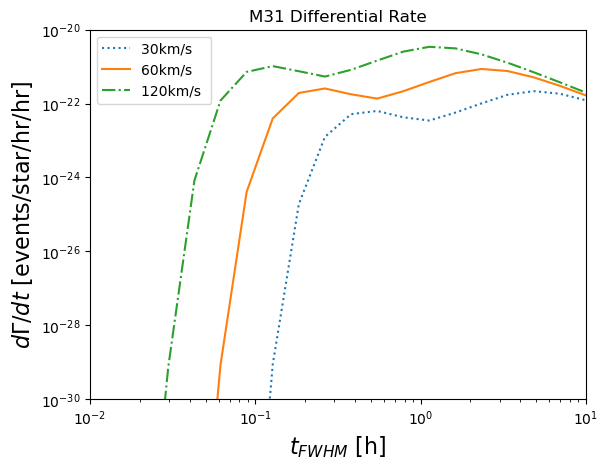

In [192]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_m31_30), label="30km/s ", linestyle=':')
plt.loglog(np.array(ts), np.array(diff_rates_finite_m31), label="60km/s ", linestyle='-')
plt.loglog(np.array(ts), np.array(diff_rates_finite_m31_120), label="120km/s ", linestyle='-.')

plt.xlabel(r"$t_{FWHM}$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.title('M31 Differential Rate')
plt.xlim(min(ts), max(ts))
plt.ylim(1e-30,1e-20)
plt.legend()
plt.show()

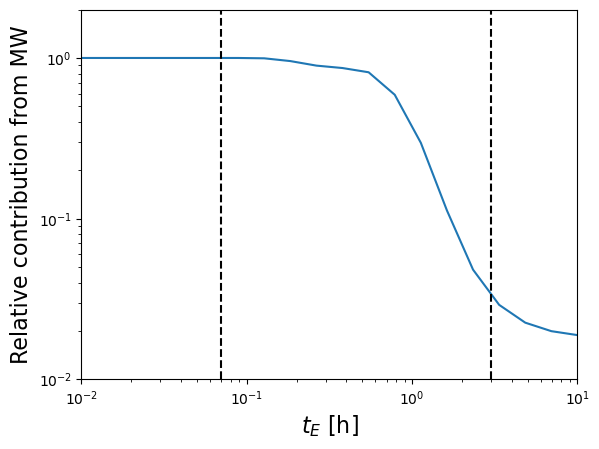

In [193]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw)/(np.array(diff_rates_finite_mw) + np.array(diff_rates_finite_m31)))
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel("Relative contribution from MW", fontsize=16)
plt.xlim(min(ts), max(ts))
plt.ylim(1e-2,2)
plt.xlim(1e-2,1e1)

plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')

plt.show()

In [194]:
interp_mw = interp1d(ts,diff_rates_finite_mw)
interp_m31 = interp1d(ts,diff_rates_finite_m31)

In [195]:
interp_mw = interp1d(ts,diff_rates_finite_mw)
interp_m31 = interp1d(ts,diff_rates_finite_m31)

print(quad(lambda t: interp_mw(t), 0.07, 3)[0]/(quad(lambda t: interp_m31(t), 0.07, 3)[0] + quad(lambda t: interp_mw(t), 0.07, 3)[0]))


0.5713535152735556


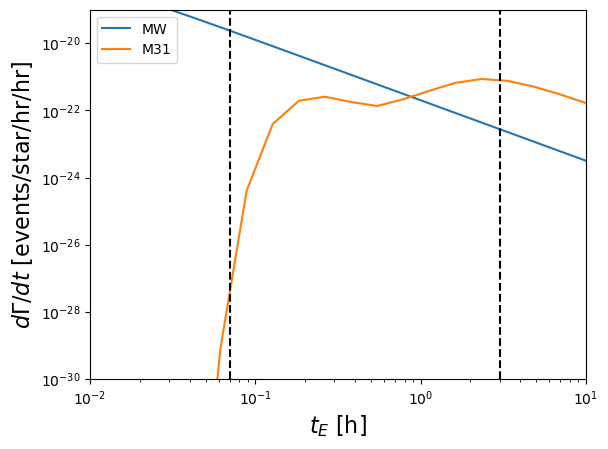

In [196]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw), label="MW")
plt.loglog(np.array(ts), np.array(diff_rates_finite_m31), label="M31")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)

plt.xlim(min(ts), max(ts))
plt.xlim(1e-2,1e1)
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')

plt.ylim(1e-30,1e-19)
plt.legend()
plt.show()

In [86]:
m_test = 1e-8

diff_rates_monochromatic_m31 = []
for t in tqdm(ts, desc='Computing differential rates (finite=True)'):
    diff_rates_monochromatic_m31.append(f.differential_rate_m31_monochromatic(t, finite=True, m=m_test))

diff_rates_monochromatic_mw = []
for t in tqdm(ts, desc='Computing differential rates (finite=True)'):
    diff_rates_monochromatic_mw.append(f.differential_rate_mw_monochromatic(t, finite=True, m=m_test))
    

Computing differential rates (finite=True): 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


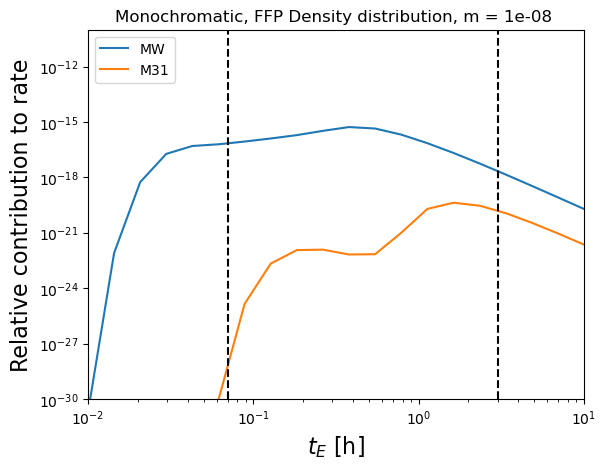

In [87]:
plt.loglog(np.array(ts), np.array(diff_rates_monochromatic_mw), label="MW")
plt.loglog(np.array(ts), np.array(diff_rates_monochromatic_m31), label="M31")

plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)

plt.xlim(min(ts), max(ts))
plt.title('Monochromatic, FFP Density distribution, m = {} '.format(m_test))
plt.ylim(1e-30,1e-10)

plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')

plt.legend()
plt.show()

In [93]:
def monochromatic_rate_ffp(m, p, return_sep=False):
    ti = 0.07
    tf = 3

    f = Ffp(p)
    ts = np.logspace(-3, 1, num=40)
    diff_rates_monochromatic_m31 = []
    diff_rates_monochromatic_mw = []
    for t in ts:
        diff_rates_monochromatic_m31.append(f.differential_rate_m31_monochromatic(t, finite=True, m=m))
        diff_rates_monochromatic_mw.append(f.differential_rate_mw_monochromatic(t, finite=True, m=m))
    
    diff_interp_m31 = interp1d(ts, diff_rates_monochromatic_m31)
    diff_interp_mw = interp1d(ts, diff_rates_monochromatic_mw)

    quad_m31 = quad(diff_interp_m31, ti, tf)[0]
    quad_mw = quad(diff_interp_mw, ti, tf)[0]

    if return_sep:
        return quad_mw, quad_m31
    
    return quad_mw, quad_m31

In [95]:
m_arr = np.logspace(-12, -2, num=30)
rates_mw = []
rates_m31 = []
p = 1
for m in tqdm(m_arr, desc='Computing differential rates (finite=True)'):
    rate_mw, rate_m31 = monochromatic_rate_ffp(m, p)
    rates_mw.append(rate_mw)
    rates_m31.append(rate_m31)

rates_mw = np.array(rates_mw)
rates_m31 = np.array(rates_m31)

Computing differential rates (finite=True): 100%|██████████| 30/30 [01:50<00:00,  3.69s/it]


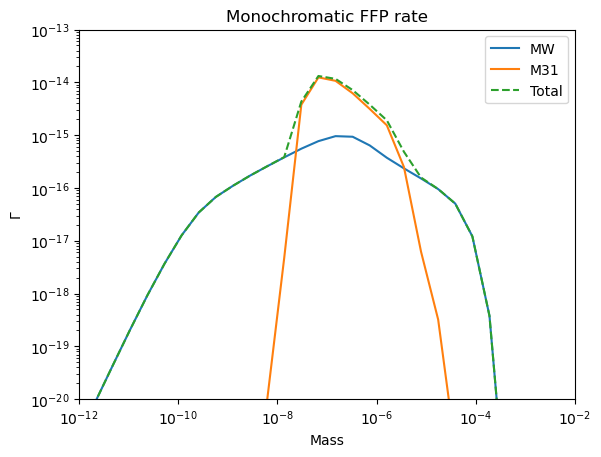

In [102]:
plt.plot(m_arr, rates_mw, label="MW")
plt.plot(m_arr, rates_m31, label="M31")
plt.plot(m_arr, rates_mw + rates_m31, label="Total", ls = "--")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Mass")
plt.ylabel(r"$\Gamma$")
plt.title("Monochromatic FFP rate")

plt.legend()

plt.xlim(min(m_arr), max(m_arr))
plt.ylim(1e-20, 1e-13)
plt.show()

#Left hand side cutoff of M31 is due to finite size effects. Why is right hand side cutoff sharp relative to MW?

In [91]:
#Test that the mass function is normalized correctly
test_close(abs(nquad(f.mass_func,[[np.log10(f.m_min), np.log10(f.m_max)]], opts={'points': [f.m_min, f.m_min*1e3, f.m_min*1e5]})[0]), 1, eps=1e-3)

### Ensure limits are independent of mass function start/end

In [99]:
#! Check this calculation after updates to FFP class
def get_n_events(A, alpha=2, finite=False, m_min=1e-15):
    #Now A is number of FFPs per star
    f = Ffp(alpha, m_min=m_min)
    ti = 0.07
    tf = 3
    t_es = np.logspace(-2, 1, num=20)
    diff_rates = f.compute_differential_rate(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return n_sources*efficiency*dnds*obsTime*A

def get_constraint_iso(m_iso, alpha=2, finite=False, m_min=1e-15):
    f = Ffp(alpha, m_min=m_min)

    if m_iso < f.m_min:
        raise ValueError('Mass must be greater than the minimum mass of the FFP mass function')
    
    n_events = get_n_events(1, alpha=alpha, finite=finite, m_min=m_min)

    #Porportion of ISOs above threshold
    proportion_above_threshold = nquad(f.mass_func,[[m_iso, f.m_max]], opts={'points': [f.m_min, f.m_min*1e3, f.m_min*1e5]})[0]*f.Z

    #Maximum number of total allowed ISOs per star
    N_thresh = 4.74/n_events

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_thresh * proportion_above_threshold    

In [ ]:
m_mins = np.logspace(-15, -7, num=24)

def get_constraint_iso_wrapped(m_min):
    return get_constraint_iso(1e-7, alpha=2, finite=True, m_min=m_min)

with Pool() as p:
   isos_per_star_arr = list(tqdm(p.imap(get_constraint_iso_wrapped, m_mins), total=len(m_mins)))

100%|██████████| 20/20 [06:52<00:00, 20.64s/it]


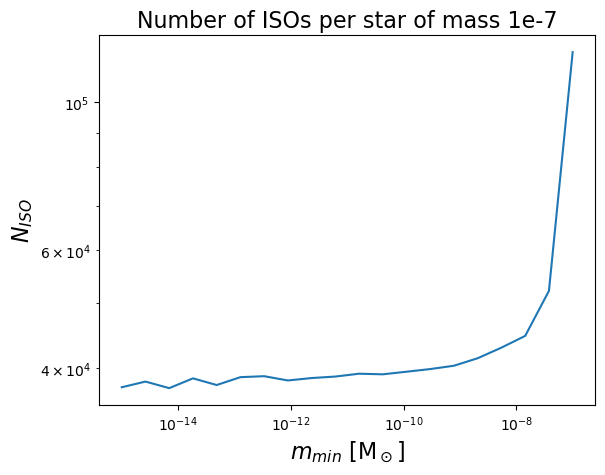

In [ ]:
# Expect to see that results are independent of m_min until the cutoff is in the range that HSC is sensitive to
# Looks good!
plt.plot(m_mins, isos_per_star_arr)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e7, 1e8)
plt.xlabel(r"$m_{min}$ [M$_\odot$]", fontsize=16)
plt.ylabel(r"$N_{ISO}$", fontsize=16)
plt.title('Number of ISOs per star of mass 1e-7', fontsize=16)
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()